In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import itertools
import time
from scipy.stats import iqr

# Step 1: Load Data

In [2]:
# -----------------
# Load the training and test datasets
df_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
df_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

# For the test dataset, add the target column 'SalePrice' with value 0 (for Combine train and test data for preprocessing)
if 'SalePrice' not in df_test.columns:
    df_test['SalePrice'] = 0
    
# Combine train and test data for preprocessing
df = pd.concat([df_train, df_test], axis = 0)
df = df.set_index('Id')

# Display the first few rows of the combined dataset
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Step 2: Handle Missing Values

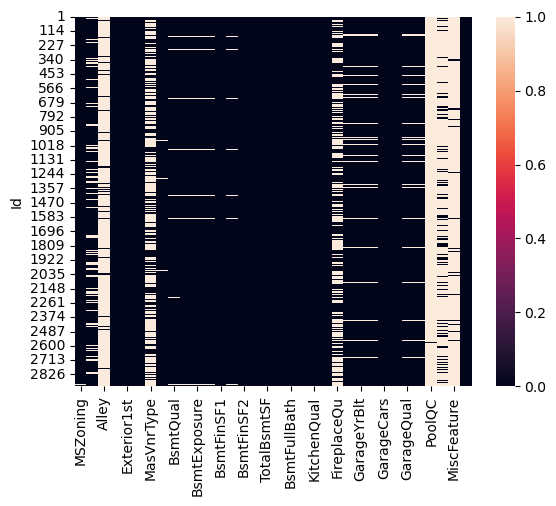

In [3]:
# -----------------------------
# Find missing values across all columns
df_mv  = df[df.isnull().sum()[df.isnull().sum()>0].index]

# Visualize missing values using a heatmap
sns.heatmap(df_mv.isnull())
plt.show()

In [4]:
# Remove categorical columns with more than 1100 missing values
df_objects =  df[df.select_dtypes(include=['object']).columns]
df = df.drop(df[df_objects.isna().sum()[df_objects.isna().sum() > 1100].index], axis = 1)

# Fill missing values of other categorical columns with 'MV' and encode them using one-hot encoding
df_objects = df_objects.drop(df_objects[df_objects.isna().sum()[df_objects.isna().sum() > 1100].index], axis = 1)
df_objects = df_objects.fillna('MV')
df_objects_encoded = pd.get_dummies(df_objects)

# Drop columns that are encoded as 'MV'
for i in df_objects_encoded.columns:
    if 'MV' in i:
        df_objects_encoded = df_objects_encoded.drop(i, axis = 1)
        print(i)
        
# Combine the original dataframe with the encoded categorical columns
new_df = pd.concat([df, df_objects_encoded], axis = 1)


MSZoning_MV

Utilities_MV

Exterior1st_MV

Exterior2nd_MV

BsmtQual_MV

BsmtCond_MV

BsmtExposure_MV

BsmtFinType1_MV

BsmtFinType2_MV

Electrical_MV

KitchenQual_MV

Functional_MV

GarageType_MV

GarageFinish_MV

GarageQual_MV

GarageCond_MV

SaleType_MV


# Step 3: Handle Missing Values in Numerical Columns

#### impute the missing values of numerical values

In [5]:
# Drop any remaining object-type columns (they've already been encoded)
new_df = new_df.drop(df.select_dtypes(include=['object']), axis = 1)

#get an overview of numerical missing values
new_df.isna().sum()[new_df.isna().sum() > 0]

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

In [6]:
# Impute missing values in numerical columns
# Use mode for ordinal features and mean for continuous features

Mode_columns = ['GarageCars', 'GarageYrBlt', 'BsmtFullBath', 'BsmtHalfBath']
Mean_columns = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                'TotalBsmtSF', 'GarageArea']

for i in Mode_columns:
    new_df[i] = new_df[i].fillna(new_df[i].mode()[0])

for i in Mean_columns:
    new_df[i] = new_df[i].fillna(np.round(new_df[i].mean()))

# check for removing all missing values
new_df.isna().sum()[new_df.isna().sum() > 0] 

Series([], dtype: int64)

# Step 4: Data Splitting

In [7]:
# ----------------------
# Separate the train and test sets from the combined dataset
train_data = new_df[0:len(df_train)]
test_data = new_df[len(df_train):]
test_data = test_data.drop(columns='SalePrice')

# Step 5: Target Variable Analysis (SalePrice)

C:\Users\amira\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):


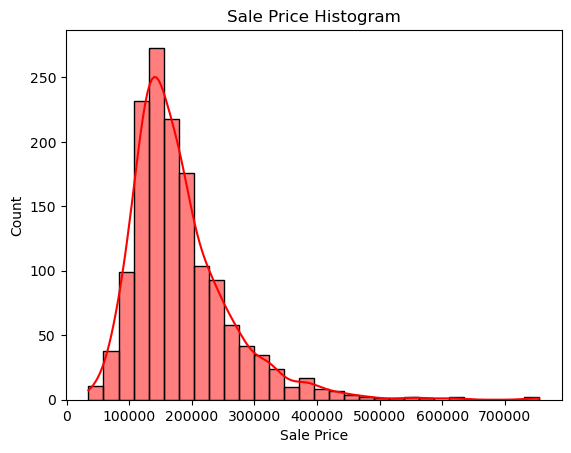

count      1460.000000

mean     180921.195890

std       79442.502883

min       34900.000000

25%      129975.000000

50%      163000.000000

75%      214000.000000

max      755000.000000

Name: SalePrice, dtype: float64


In [8]:
# --------------------------------------------
# Visualize the distribution of SalePrice
sns.histplot(data=train_data, x="SalePrice", color="red", kde=True, bins=30)
plt.title("Sale Price Histogram")
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.show()

# Display SalePrice summary statistics
print(train_data["SalePrice"].describe())

In [9]:
# Apply Box-Cox transformation to SalePrice to normalize its distribution
from sklearn.preprocessing import PowerTransformer
y_train = train_data['SalePrice']
boxcox = PowerTransformer(method = 'box-cox')
boxcox.fit(y_train.values.reshape(-1, 1))
trans_y_train = boxcox.fit_transform(y_train.values.reshape(-1, 1))

C:\Users\amira\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):


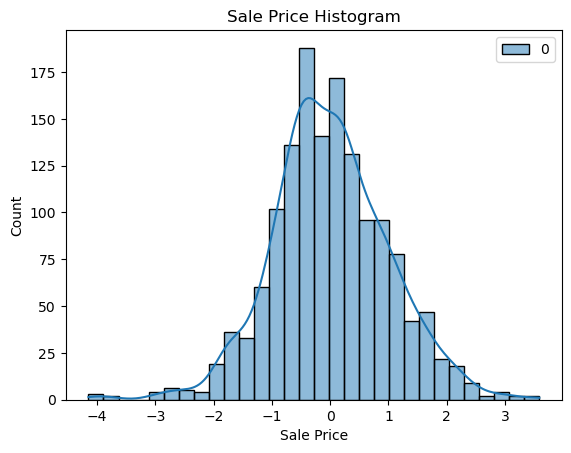

In [10]:
# Visualize the transformed SalePrice distribution
sns.histplot(trans_y_train, color="red", kde=True, bins=30)
plt.title("Sale Price Histogram")
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.show()

In [11]:
# Write preprocessed data to a CSV file for further analysis
train_data.to_csv('train_data.csv', index=True)
test_data.to_csv('test_data.csv', index=True)

# Step 6: Split Data into Training and Validation Sets

In [12]:
# ----------------------------------------------------
#Split data into test and train
train, test = train_test_split(train_data, 
                               test_size = 0.3, 
                               random_state = 724)
print(train.shape)
print(test.shape)

(1022, 267)

(438, 267)


In [13]:
# Define feature matrices and target vectors for train set
X_train = train.drop(['SalePrice'], axis = 1)
X_train.head()

y_train = train['SalePrice']
y_train

#Box-Cox transformation for target variable in train set
from sklearn.preprocessing import PowerTransformer
boxcox = PowerTransformer(method = 'box-cox')
boxcox.fit(y_train.values.reshape(-1, 1))
trans_y_train = boxcox.fit_transform(y_train.values.reshape(-1, 1))

In [14]:
# Define feature matrices and target vectors for validation set
X_test = test.drop(['SalePrice'], axis = 1)
X_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
637,30,51.0,6120,2,3,1936,1950,0.0,0.0,0.0,...,True,False,False,False,False,False,False,False,True,False
769,20,70.0,9100,7,5,2004,2005,0.0,24.0,0.0,...,False,False,False,True,False,False,False,False,True,False
1417,190,60.0,11340,4,6,1885,1950,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,True,False
1457,20,85.0,13175,6,6,1978,1988,119.0,790.0,163.0,...,False,False,False,True,False,False,False,False,True,False
654,50,60.0,10320,6,7,1906,1995,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,True,False


# Step 7: Train Random Forest Model

In [15]:
# ---------------------------------
# Initialize and train a Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators = 2000,
                               max_features = X_train.shape[1], 
                               criterion = 'squared_error',
                               max_depth = 20, 
                               min_samples_leaf = 4, 
                               ccp_alpha = 0,
                               random_state = 724)

model_1 = rf_reg.fit(X_train, trans_y_train.reshape(-1))

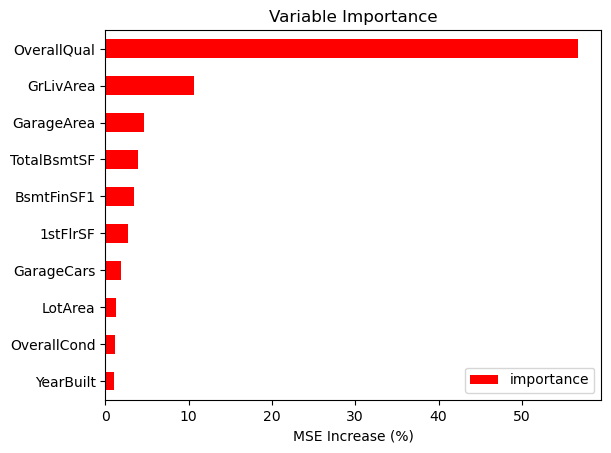

In [16]:
# Evaluate feature importance
importance = pd.DataFrame({'importance': model_1.feature_importances_ * 100}, 
                          index = X_train.columns)
filtered_importance = importance[importance['importance'] > 1]
filtered_importance.sort_values(by = 'importance', axis = 0, ascending = True).plot(kind = 'barh',color = 'r')
plt.title('Variable Importance')
plt.xlabel('MSE Increase (%)')
plt.show()

In [17]:
# Hyperparameter Tuning using Cross-Validation for RandomForest
# ----------------------------------------------------
# Create hyperparameter grid for Random Forest
n_estimators = [2000, 2100]
max_features = ['sqrt', 'log2', None] #If None or 1.0, then max_features = n_features
max_depth = [20, 25]
min_samples_leaf = [4, 5, 6]
params_grid = list(itertools.product(n_estimators, max_features, max_depth, min_samples_leaf))
params_grid = pd.DataFrame(data = params_grid,
                           index = range(1, 37), 
                           columns = ['n_estimators', 
                                      'max_features', 
                                      'max_depth', 
                                      'min_samples_leaf'])
params_grid

,n_estimators,max_features,max_depth,min_samples_leaf
1,2000,sqrt,20,4
2,2000,sqrt,20,5
3,2000,sqrt,20,6
4,2000,sqrt,25,4
5,2000,sqrt,25,5
6,2000,sqrt,25,6
7,2000,log2,20,4
8,2000,log2,20,5
9,2000,log2,20,6
10,2000,log2,25,4


In [18]:
# Perform 5-fold cross-validation to choose the best hyperparameter
start_time = time.time()
cv_errors = np.zeros(shape = len(params_grid)) #to save cv results
for i in range(len(params_grid)):
    rf_reg = RandomForestRegressor(n_estimators = params_grid.iloc[i, 0],
                                   max_features = params_grid.iloc[i, 1], 
                                   criterion = 'squared_error',
                                   max_depth = params_grid.iloc[i, 2], 
                                   min_samples_leaf = params_grid.iloc[i, 3], 
                                   ccp_alpha = 0,
                                  random_state= 42)
    scores = cross_val_score(estimator = rf_reg, 
                             X = X_train, 
                             y = trans_y_train,
                             scoring = 'neg_root_mean_squared_error',
                             cv = 5, n_jobs = -1)
    cv_errors[i] = scores.mean() 
end_time = time.time()
print('The Processing time is: ', end_time - start_time, 'seconds')

cv_errors

The Processing time is:  694.5979351997375 seconds


array([-0.40465751, -0.41211826, -0.41949025, -0.40467688, -0.41211838,
       -0.41949025, -0.4512881 , -0.46159415, -0.4721903 , -0.45132483,
       -0.4615807 , -0.47218764, -0.38738623, -0.3903265 , -0.393609  ,
       -0.38738584, -0.3903265 , -0.393609  , -0.40473063, -0.41211603,
       -0.41957227, -0.40474914, -0.41211614, -0.41957227, -0.45108437,
       -0.46156999, -0.47206454, -0.4511203 , -0.46155718, -0.47206201,
       -0.38728562, -0.39025897, -0.39351394, -0.38728524, -0.39025897,
       -0.39351394])

In [19]:
# Find the best model
best_params = params_grid.iloc[np.argmax(cv_errors), :]
print(f'Best Random Forest parameters: {best_params}')

Best Random Forest parameters: n_estimators        2100

max_features        None

max_depth             25

min_samples_leaf       4

Name: 34, dtype: object


In [20]:
# Retrain the Random Forest model with the best parameters
rf_reg = RandomForestRegressor(n_estimators = params_grid.iloc[np.argmax(cv_errors), 0],
                               max_features = params_grid.iloc[np.argmax(cv_errors), 1], 
                               criterion = 'squared_error',
                               max_depth = params_grid.iloc[np.argmax(cv_errors), 2], 
                               min_samples_leaf = params_grid.iloc[np.argmax(cv_errors), 3], 
                               ccp_alpha = 0,
                               random_state = 42)
model_1 = rf_reg.fit(X_train, trans_y_train.reshape(-1))

#Prediction using model 1
pred_rf = model_1.predict(X_test)
pred_rf = pd.Series(boxcox.inverse_transform(pred_rf.reshape(-1, 1)).reshape(-1), 
                    index = test.index)
pred_rf

Id
637      65169.524564
769     223688.866695
1417    121915.311214
1457    199468.246061
654     133527.743031
            ...      
1147    174065.968828
1347    222805.908791
196     152365.573202
1221    117598.301006
939     237719.235952
Length: 438, dtype: float64

In [21]:
#Absolute error
abs_err_rf = abs(test['SalePrice'] - pred_rf)

#Absolute error mean, median, sd, IQR, max, min
from scipy.stats import iqr
models_comp = pd.DataFrame({'Mean of AbsErrors':    abs_err_rf.mean(),
                                       'Median of AbsErrors' : abs_err_rf.median(),
                                       'SD of AbsErrors' :     abs_err_rf.std(),
                                       'IQR of AbsErrors':     iqr(abs_err_rf),
                                       'Min of AbsErrors':     abs_err_rf.min(),
                                       'Max of AbsErrors':     abs_err_rf.max()}, 
                                      index = ['Random Forest'])
models_comp

,Mean of AbsErrors,Median of AbsErrors,SD of AbsErrors,IQR of AbsErrors,Min of AbsErrors,Max of AbsErrors
Random Forest,18813.871644,11563.660105,27202.236825,17304.332417,3.929299,260332.756299


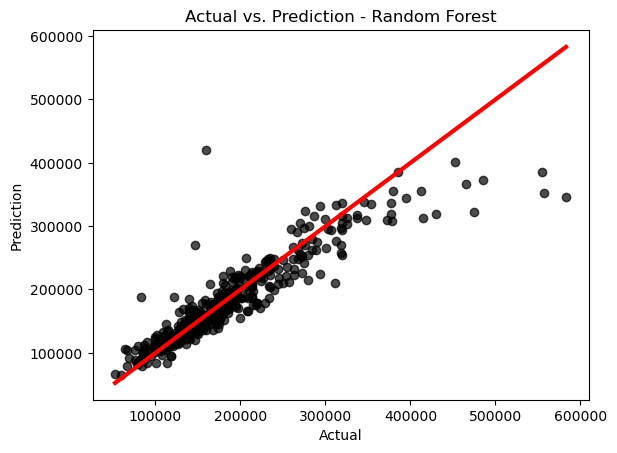

In [22]:
#Actual vs. Prediction
plt.scatter(x = test['SalePrice'], y = pred_rf, c = 'black', alpha = 0.7)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Actual vs. Prediction - Random Forest')

#Add 45 degree line
xp = np.linspace(test['SalePrice'].min(), test['SalePrice'].max(), 100)
plt.plot(xp, xp, c = 'red', linewidth = 3)
plt.show()

# Step 8: Gradient Boosting Regressor

In [23]:
# -----------------------------------
# Initialize and train a Gradient Boosting Regressor (not tuned)
boosting_reg = GradientBoostingRegressor(learning_rate = 0.05,  #learning rate
                                         n_estimators = 300,   #the total number of trees to fit
                                         subsample = 0.7,      #the fraction of samples to be used,  
                                                                    #if .< 1, Stochastic GB
                                         max_depth = 5,        #the maximum depth of each tree
                                         min_samples_leaf = 16, #the minimum number of observations in the leaf nodes of the trees
                                         random_state = 42)

model_2 = boosting_reg.fit(X_train, trans_y_train.reshape(-1))

In [24]:
# Hyperparameter Tuning using Cross-Validation for GradientBoosting
# ----------------------------------------------------
# Create hyperparameter grid
learning_rate = [0.04, 0.05, 0.06 ]
n_estimators = [250, 300, 350]
subsample = [0.6, 0.7, 0.9]
max_depth = [3, 4, 5]
min_samples_leaf = [4, 8, 16]

params_grid = list(itertools.product(learning_rate, n_estimators, subsample, max_depth, min_samples_leaf))
params_grid = pd.DataFrame(data = params_grid,
                           index = range(1,244), 
                           columns = ['learning_rate',
                                      'n_estimators', 
                                      'subsample', 
                                      'max_depth', 
                                      'min_samples_leaf'])
params_grid

,learning_rate,n_estimators,subsample,max_depth,min_samples_leaf
1,0.04,250,0.6,3,4
2,0.04,250,0.6,3,8
3,0.04,250,0.6,3,16
4,0.04,250,0.6,4,4
5,0.04,250,0.6,4,8
...,...,...,...,...,...
239,0.06,350,0.9,4,8
240,0.06,350,0.9,4,16
241,0.06,350,0.9,5,4
242,0.06,350,0.9,5,8


In [25]:
#K-fold cross validation to choose the best model

start_time = time.time()
cv_errors = np.zeros(shape = len(params_grid)) #to save cv results
for i in range(len(params_grid)):
    gb_reg = GradientBoostingRegressor(learning_rate = params_grid.iloc[i, 0],
                                       n_estimators = params_grid.iloc[i, 1], 
                                       subsample = params_grid.iloc[i, 2], 
                                       max_depth = params_grid.iloc[i, 3],
                                       min_samples_leaf = params_grid.iloc[i, 4],
                                       random_state = 42)
    scores = cross_val_score(estimator = gb_reg, 
                             X = X_train, 
                             y = trans_y_train,
                             scoring = 'neg_root_mean_squared_error',
                             cv = 5, n_jobs = -1)
    cv_errors[i] = scores.mean() 
end_time = time.time()
print('The Processing time is: ', end_time - start_time, 'seconds')

cv_errors

The Processing time is:  838.7350482940674 seconds


array([-0.3324669 , -0.33347868, -0.33486117, -0.33305052, -0.33543955,
       -0.33511803, -0.33641839, -0.33321828, -0.33513902, -0.33232094,
       -0.33520446, -0.33314666, -0.33216058, -0.33541739, -0.33575556,
       -0.3382566 , -0.33901354, -0.33693195, -0.33987548, -0.34389593,
       -0.33856652, -0.34292022, -0.34548786, -0.33946148, -0.34593551,
       -0.34231203, -0.34225298, -0.33017472, -0.33193166, -0.33391361,
       -0.33151338, -0.33422059, -0.3346738 , -0.33610583, -0.33315615,
       -0.3355993 , -0.32957116, -0.33359764, -0.33151893, -0.33050142,
       -0.33514053, -0.33513364, -0.33797043, -0.33849727, -0.33701858,
       -0.33669257, -0.34189374, -0.33623176, -0.34115869, -0.34419537,
       -0.33813729, -0.34536924, -0.34233515, -0.34204717, -0.32864098,
       -0.33099847, -0.33297361, -0.33075134, -0.33378961, -0.33453086,
       -0.33532576, -0.33389318, -0.33538134, -0.32766094, -0.33267787,
       -0.33053004, -0.32938398, -0.3353596 , -0.33461254, -0.33

In [26]:
# Find the best model hyperparameters
best_params = params_grid.iloc[np.argmax(cv_errors), :]
print(f'Best Random Forest parameters: {best_params}')

Best Random Forest parameters: learning_rate         0.06

n_estimators        350.00

subsample             0.60

max_depth             3.00

min_samples_leaf      4.00

Name: 217, dtype: float64


In [27]:
# Retrain model 2 with best hyperparmeters
boosting_reg = GradientBoostingRegressor(
    learning_rate = params_grid.iloc[np.argmax(cv_errors), 0],
    n_estimators = params_grid.iloc[np.argmax(cv_errors), 1],
    subsample = params_grid.iloc[np.argmax(cv_errors), 2],
    max_depth= params_grid.iloc[np.argmax(cv_errors), 3],
    min_samples_leaf = params_grid.iloc[i, 4],
    random_state = 42)
    
model_2 = boosting_reg.fit(X_train, trans_y_train.reshape(-1))

In [28]:
#Prediction using model 2
pred_gbr = model_2.predict(X_test)
pred_gbr = pd.Series(boxcox.inverse_transform(pred_gbr.reshape(-1, 1)).reshape(-1), 
                    index = test.index)
pred_gbr

Id
637      48902.051213
769     215569.656903
1417    124595.494353
1457    206555.243837
654     128131.206951
            ...      
1147    166323.343587
1347    257260.037967
196     152490.581198
1221    110625.946899
939     245666.642552
Length: 438, dtype: float64

In [29]:
#Absolute error
abs_err_gbr = abs(test['SalePrice'] - pred_gbr)

#Absolute error mean, median, sd, IQR, max, min
from scipy.stats import iqr
models_comp = pd.concat([models_comp,
                         pd.DataFrame({'Mean of AbsErrors':    abs_err_gbr.mean(),
                                       'Median of AbsErrors' : abs_err_gbr.median(),
                                       'SD of AbsErrors' :     abs_err_gbr.std(),
                                       'IQR of AbsErrors':     iqr(abs_err_gbr),
                                       'Min of AbsErrors':     abs_err_gbr.min(),
                                       'Max of AbsErrors':     abs_err_gbr.max()}, 
                                      index = ['GB Regressor'])])
models_comp

,Mean of AbsErrors,Median of AbsErrors,SD of AbsErrors,IQR of AbsErrors,Min of AbsErrors,Max of AbsErrors
Random Forest,18813.871644,11563.660105,27202.236825,17304.332417,3.929299,260332.756299
GB Regressor,16212.839726,10038.999493,22822.913074,14104.018946,0.084992,268007.015886


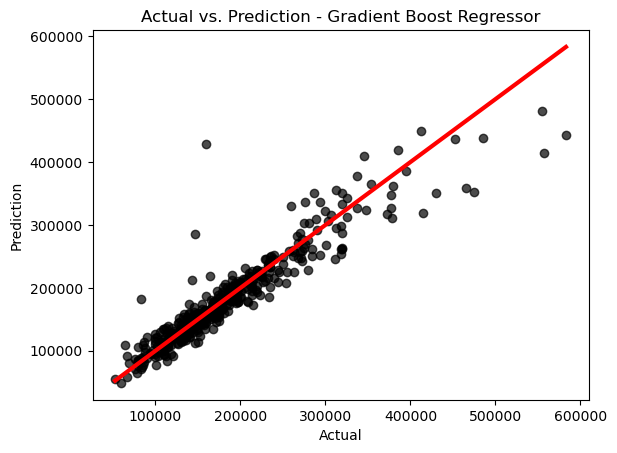

In [30]:
#Actual vs. Prediction
plt.scatter(x = test['SalePrice'], y = pred_gbr, c = 'black', alpha = 0.7)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Actual vs. Prediction - Gradient Boost Regressor')

#Add 45 degree line
xp = np.linspace(test['SalePrice'].min(), test['SalePrice'].max(), 100)
plt.plot(xp, xp, c = 'red', linewidth = 3)
plt.show()

# Final Step: prediction on test set and create submission file

In [31]:
pred = model_2.predict(test_data)

pred = pd.Series(boxcox.inverse_transform(pred.reshape(-1, 1)).reshape(-1),
                 index = test_data.index)

final = pd.DataFrame()
final['Id'] = pred.index
final['SalePrice'] = pred.tolist()

# Write DataFrame to a CSV file without index
final.to_csv('submission.csv', index=False)

In [32]:
final

,Id,SalePrice
0,1461,123025.106993
1,1462,157073.343606
2,1463,178127.977806
3,1464,187486.835918
4,1465,188472.152516
...,...,...
1454,2915,80779.243151
1455,2916,76456.427234
1456,2917,151612.736626
1457,2918,124211.535454
